In [27]:
import pickle
import sys
import time
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pyccl as ccl
from scipy.special import erf
import ray

ray.shutdown()
ray.init()

# get project directory adn import useful modules
project_path = Path.cwd().parent

sys.path.append(f'{project_path.parent}/common_data/common_lib')
sys.path.insert(1, f'{project_path.parent}/PyCCL_SSC/lib')
sys.path.insert(1, f'{project_path.parent}/PyCCL_SSC/config')
import my_module as mm

sys.path.append(f'{project_path.parent}/SSC_restructured_v2/bin')
import ell_values as ell_utils

sys.path.append(f'{project_path.parent}/common_data/common_config')
import ISTF_fid_params as ISTF_fid
#import mpl_cfg

sys.path.append(f'{project_path}/config')
import PyCCL_config as cfg

#matplotlib.use('Qt5Agg')
start_time = time.perf_counter()
#plt.rcParams.update(mpl_cfg.mpl_rcParams_dict)


###############################################################################
###############################################################################
###############################################################################

def bias(z, zi):
    zbins = len(zi[0])
    z_minus = zi[0, :]  # lower edge of z_hm bins
    z_plus = zi[1, :]  # upper edge of z_hm bins
    z_mean = (z_minus + z_plus) / 2  # cener of the z_hm bins

    for i in range(zbins):
        if z_minus[i] <= z < z_plus[i]:
            return b(i, z_mean)
        if z > z_plus[-1]:  # max redshift bin
            return b(9, z_mean)


def b(i, z_mean):
    return np.sqrt(1 + z_mean[i])


def cl_PyCCL(cosmo, kernel_A, kernel_B, ell, Pk, zbins):
    result = np.array([[ccl.angular_cl(cosmo, kernel_A[iz], kernel_B[jz], ell, p_of_k_a=Pk)
                        for iz in range(zbins)]
                       for jz in range(zbins)])
    return result

def magbias_of_z_fs2_fit(z, maglim, poly_fit_values=None):
    # from the MCMC for SPV3 google doc: https://docs.google.com/document/d/1WCGhiBrlTsvl1VS-2ngpjirMnAS-ahtnoGX_7h8JoQU/edit
    if maglim == 24.5:
        b0_mag, b1_mag, b2_mag, b3_mag = -1.50685, 1.35034, 0.08321, 0.04279
    elif maglim == 23:
        b0_mag, b1_mag, b2_mag, b3_mag = -2.34493, 3.73098, 0.12500, -0.01788
    else:
        raise ValueError('maglim, i.e. the limiting magnitude of the GCph sample, must be 23 or 24.5')

    if poly_fit_values is not None:
        assert len(poly_fit_values) == 4, 'a list of 4 best-fit values must be passed'
        np.testing.assert_allclose(np.array(poly_fit_values), np.array((b0_mag, b1_mag, b2_mag, b3_mag)), atol=0,
                                   rtol=1e-5)

    return b0_mag + (b1_mag * z) + (b2_mag * z ** 2) + (b3_mag * z ** 3)

def s_of_z_fs2_fit(z, maglim, poly_fit_values=None):
    # from the MCMC for SPV3 google doc: https://docs.google.com/document/d/1WCGhiBrlTsvl1VS-2ngpjirMnAS-ahtnoGX_7h8JoQU/edit

    return (magbias_of_z_fs2_fit(z, maglim, poly_fit_values=poly_fit_values)+2)/5


###############################################################################
###############################################################################
###############################################################################

# ! POTENTIAL ISSUES:
# 1. input files (WF, ell, a, pk...)
# 2. halo model recipe
# 3. ordering of the resulting covariance matrix
# * fanstastic collection of notebooks: https://github.com/LSSTDESC/CCLX


# ! settings
ell_recipe = cfg.general_cfg['ell_recipe']
probes = cfg.general_cfg['probes']
which_NGs = cfg.general_cfg['which_NGs']
save_covs = cfg.general_cfg['save_covs']
hm_recipe = cfg.general_cfg['hm_recipe']
GL_or_LG = cfg.general_cfg['GL_or_LG']
ell_min = cfg.general_cfg['ell_min']
ell_max = cfg.general_cfg['ell_max']
nbl = cfg.general_cfg['nbl']
zbins = cfg.general_cfg['zbins']
use_ray = cfg.general_cfg['use_ray']  # TODO finish this!
# ! settings

# get number of redshift pairs
zpairs_auto, zpairs_cross, zpairs_3x2pt = mm.get_zpairs(zbins)

# Create new Cosmology object with a given set of parameters. This keeps track of previously-computed cosmological
# functions
Om_c0 = ISTF_fid.primary['Om_m0'] - ISTF_fid.primary['Om_b0']
cosmo = ccl.Cosmology(Omega_c=Om_c0, Omega_b=ISTF_fid.primary['Om_b0'], w0=ISTF_fid.primary['w_0'],
                      wa=ISTF_fid.primary['w_a'], h=ISTF_fid.primary['h_0'], sigma8=ISTF_fid.primary['sigma_8'],
                      n_s=ISTF_fid.primary['n_s'], m_nu=ISTF_fid.extensions['m_nu'],
                      Omega_k=1 - (Om_c0 + ISTF_fid.primary['Om_b0']) - ISTF_fid.extensions['Om_Lambda0'])

################################## Define redshift distribution of sources kernels #####################################
zmin, zmax, dz = 0.001, 2.5, 0.001
ztab = np.arange(zmin, zmax, dz)  # ! should it start from 0 instead?

mag_bias_1d = s_of_z_fs2_fit(ztab, maglim=24.5)
mag_bias_tuple = (ztab, mag_bias_1d)
print(mag_bias_tuple)
# for CosmoLike
# zmin, zmax, zsteps = 0.001, 4., 10_000
# ztab = np.linspace(zmin, zmax, zsteps)  # ! should it start from 0 instead?

z_median = ISTF_fid.photoz_bins['z_median']

# TODO import these from IST_fid
zbins_edges = np.array([[zmin, 0.418, 0.56, 0.678, 0.789, 0.9, 1.019, 1.155, 1.324, 1.576],
                        [0.418, 0.56, 0.678, 0.789, 0.9, 1.019, 1.155, 1.324, 1.576, zmax]])
# assert (zbins == len(zbins_edges[0])), 'zbins and zbins_edges do not match'

# other useful parameters
n_gal = ISTF_fid.other_survey_specs['n_gal']
survey_area = ISTF_fid.other_survey_specs['survey_area']
f_sky = survey_area * (np.pi / 180) ** 2 / (4 * np.pi)
# n_gal_degsq = n_gal * (180 * 60 / np.pi) ** 2
# sigma_e = ISTF_fid.other_survey_specs['sigma_eps']


fout = ISTF_fid.photoz_pdf['f_out']
cb, zb, sigmab = ISTF_fid.photoz_pdf['c_b'], ISTF_fid.photoz_pdf['z_b'], ISTF_fid.photoz_pdf['sigma_b']
c0, z0, sigma0 = ISTF_fid.photoz_pdf['c_o'], ISTF_fid.photoz_pdf['z_o'], ISTF_fid.photoz_pdf['sigma_o']

nzEuclid = n_gal * (ztab / z_median * np.sqrt(2)) ** 2 * np.exp(-(ztab / z_median * np.sqrt(2)) ** 1.5)

nziEuclid = np.array([nzEuclid * 1 / 2 / c0 / cb * (cb * fout *
                                                    (erf((ztab - z0 - c0 * zbins_edges[0, iz]) / np.sqrt(2) /
                                                         (1 + ztab) / sigma0) -
                                                     erf((ztab - z0 - c0 * zbins_edges[1, iz]) / np.sqrt(2) /
                                                         (1 + ztab) / sigma0)) +
                                                    c0 * (1 - fout) *
                                                    (erf((ztab - zb - cb * zbins_edges[0, iz]) / np.sqrt(2) /
                                                         (1 + ztab) / sigmab) -
                                                     erf((ztab - zb - cb * zbins_edges[1, iz]) / np.sqrt(2) /
                                                         (1 + ztab) / sigmab))) for iz in range(zbins)])


# normalize nz: this should be the denominator of Eq. (112) of IST:f
for i in range(zbins):
    norm_factor = np.sum(nziEuclid[i, :]) * dz
    nziEuclid[i, :] /= norm_factor

# ! save nziEuclid for CosmoLike
# nziEuclid_tosave = np.insert(nziEuclid.copy(), values=ztab, obj=0, axis=0).T


# plt.xlabel('$z_hm$')
# plt.ylabel('$n_i(z_hm)\,[\mathrm{arcmin}^{-2}]$')
# [plt.plot(ztab, nziEuclid[iz]) for iz in range(Nbins)]
# plt.show()

# Intrinsic alignment and galaxy bias
IAFILE = np.genfromtxt(project_path / 'input/scaledmeanlum-E2Sa.dat')
FIAzNoCosmoNoGrowth = -1 * 1.72 * 0.0134 * (1 + IAFILE[:, 0]) ** (-0.41) * IAFILE[:, 1] ** 2.17
FIAz = FIAzNoCosmoNoGrowth * (cosmo.cosmo.params.Omega_c + cosmo.cosmo.params.Omega_b) / ccl.growth_factor(cosmo, 1 / (
        1 + IAFILE[:, 0]))

b_array = np.asarray([bias(z, zbins_edges) for z in ztab])

# compute the kernels
wil = [ccl.WeakLensingTracer(cosmo, dndz=(ztab, nziEuclid[iz]), ia_bias=(IAFILE[:, 0], FIAz), use_A_ia=False)
       for iz in range(zbins)]
wig = [ccl.tracers.NumberCountsTracer(cosmo, has_rsd=False, dndz=(ztab, nziEuclid[iz]), bias=(ztab, b_array),
                                      mag_bias=mag_bias_tuple) for iz in range(zbins)]

# save wf and cl for validation
# np.save(project_path / 'output/wl_and_cl_validation/ztab.npy', ztab)
# np.save(project_path / 'output/wl_and_cl_validation/wil_array.npy', wil_array)
# np.save(project_path / 'output/wl_and_cl_validation/wig_array.npy', wig_array)
# np.save(project_path / 'output/wl_and_cl_validation/ell.npy', ell)
# np.save(project_path / 'output/wl_and_cl_validation/C_LL.npy', CLL)
# np.save(project_path / 'output/wl_and_cl_validation/nziEuclid.npy', nziEuclid)


2023-11-29 00:29:07,020	INFO worker.py:1673 -- Started a local Ray instance.


(array([1.000e-03, 2.000e-03, 3.000e-03, ..., 2.497e+00, 2.498e+00,
       2.499e+00]), array([0.09890008, 0.0991702 , 0.09944035, ..., 1.00999076, 1.01050409,
       1.01101759]))


In [21]:
x = np.linspace(0,1000, 100)
y = wig[0].get_kernel(x)


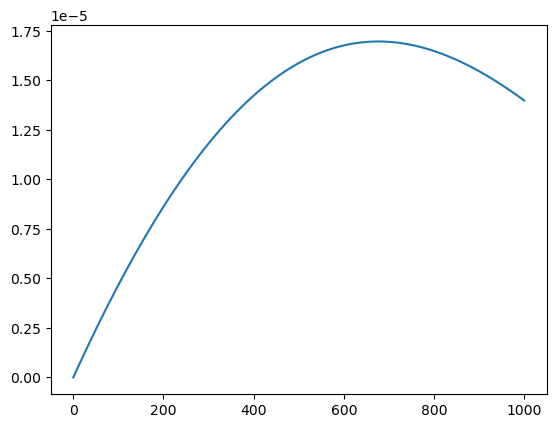

In [23]:
#plt.plot(x, y[0,:])
plt.plot(x, y[1,:])
